In [2]:
# Carrega as variáveis de embiente usadas pelo notebook. Estas variáveis devem ser criadas no arquivo .env, localizada no mesmo diretório do notebook
# As seguintes variáveis devem ser criadas:
# - export STR_CON=<string de conexão com o banco de dados relacional>
# - export RAW_DATA_PATH=<caminho onde os arquivos contendo o histórico de preço de cada ativo será armazenado>
# - export DATASET_PATH=<caminho onde os arquivos contendo o histórico de preço e os indicadores técnicos serão armazenados>
# - export MODELS_PATH=<caminnho onde os modelos treinados serão armazenados>
# - export TRAIN_DATASET=<caminho onde os datasets estandarizados e formatados para o treinamento serão armazenados>
%load_ext dotenv
%dotenv

# Garante que os scripts Python sejam recarregados em cada execução do notebook.
%load_ext autoreload
%autoreload 2

In [7]:
import os
import pandas as pd
import numpy as np
import talib as ta
from data_preparation import PreProcess, PivotLevels
from db_access import StockHistory, ExportToParquet, ExportToPickle
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from keras.models import load_model

pd.options.display.max_columns = 200

In [12]:
model = load_model("data/tf_models/autoencoder/autoencoder_26-0.0462.h5")
for layer in model.layers[1:]:
  print(type(layer))

<class 'keras.layers.rnn.lstm.LSTM'>
<class 'keras.layers.rnn.lstm.LSTM'>
<class 'keras.layers.reshaping.repeat_vector.RepeatVector'>
<class 'keras.layers.rnn.lstm.LSTM'>
<class 'keras.layers.rnn.lstm.LSTM'>
<class 'keras.layers.rnn.time_distributed.TimeDistributed'>


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dense_22_input (InputLayer)    [(None, 38)]         0           []                               
                                                                                                  
 dense_22 (Dense)               (None, 38)           1482        ['dense_22_input[0][0]']         
                                                                                                  
 dropout_12 (Dropout)           (None, 38)           0           ['dense_22[0][0]']               
                                                                                                  
 dense_23 (Dense)               (None, 38)           1482        ['dropout_12[0][0]']             
                                                                                            

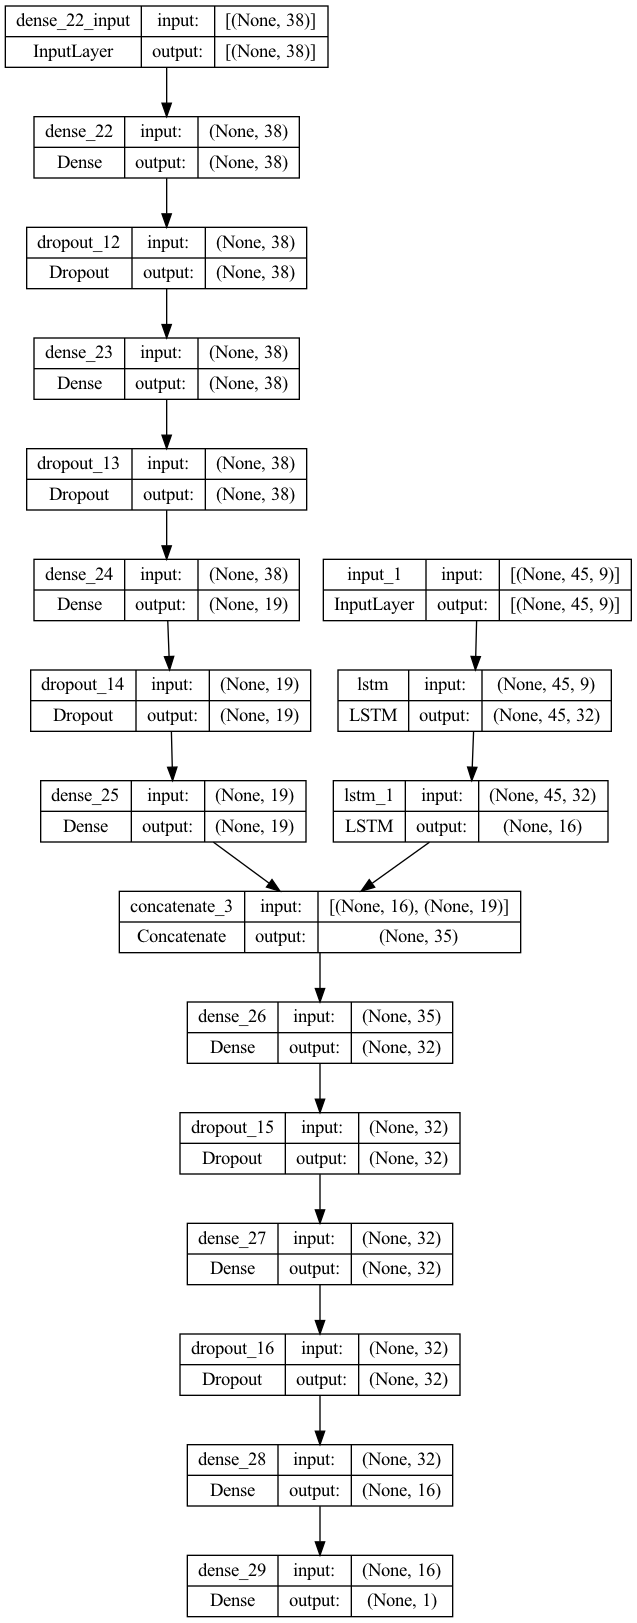

In [18]:
from keras.layers import CuDNNLSTM, Input, RepeatVector, TimeDistributed, Dense, concatenate, Dropout
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import plot_model


preprocess = PreProcess()
metric = "AUC"

# Define os callback que serão usados no treinamento do modelo
cb_early_stopping = EarlyStopping(monitor=f'val_{metric.lower()}', 
                               patience=20, 
                               min_delta=0.0005, 
                               mode='max')

cb_model_checkpoint = ModelCheckpoint("data/tf_models/final_model/model-test-{epoch:02d}-{val_auc:.4f}.h5",
                                      monitor=f'val_{metric.lower()}',
                                      save_best_only=True,
                                      verbose=1,
                                      mode="max")

cb_reduce_lr_on_plateu = ReduceLROnPlateau(monitor=f"val_{metric.lower()}",
                                            factor=0.1,
                                            patience=10,
                                            verbose=0,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=0,
                                            min_lr=0.0000001
                                          )

df_train = preprocess.read_dataset_from_parquet("data/train_dataset/indicadores_com_sinais/train_data.parquet")
df_test = preprocess.read_dataset_from_parquet("data/train_dataset/indicadores_com_sinais/test_data.parquet")

X_TS_Train = np.array([val[0] for val in df_train.values])
X_TS_Test = np.array([val[0] for val in df_test.values])

Y_train = df_train.pop('label')
Y_test = df_test.pop('label')

X_SIG_Train = df_train[df_train.columns[~df_train.columns.isin(['series'])]].values
X_SIG_Test = df_test[df_test.columns[~df_test.columns.isin(['series'])]].values

# Rede LSTM
# input_ts_data = Input((X_TS_Train.shape[1], X_TS_Train.shape[2]) )
# lstm_layer = CuDNNLSTM(32, input_shape=X_TS_Train.shape, return_sequences=True)(input_ts_data)
# lstm_layer = Dropout(0.2)(lstm_layer)
# lstm_layer = CuDNNLSTM(16, input_shape=X_TS_Train.shape)(lstm_layer)
# lstm_layer = Dense(16, activation="relu")(lstm_layer)
# model_lstm = Model(input_ts_data, lstm_layer)
model = load_model("data/tf_models/autoencoder/autoencoder_26-0.0462.h5")
for layer in model.layers[1:]:
  layer.trainable = False


model_lstm = Model(model.input, model.layers[2].output)

# Rede MLP para tratar os sinais de negociação
mlp = Sequential()
mlp.add(Dense(X_SIG_Train.shape[1], input_dim = X_SIG_Train.shape[1], activation="relu"))
mlp.add(Dropout(0.2))
mlp.add(Dense(X_SIG_Train.shape[1], activation="relu"))
mlp.add(Dropout(0.2))
mlp.add(Dense(X_SIG_Train.shape[1]//2, activation="relu"))
mlp.add(Dropout(0.2))
mlp.add(Dense(X_SIG_Train.shape[1]//2, activation="relu"))

# Concatena os modelos
final_layers = concatenate([model_lstm.output, mlp.output])
final_layers = Dense(32, activation="relu")(final_layers)
final_layers = Dropout(0.2)(final_layers)
final_layers = Dense(32, activation="relu")(final_layers)
final_layers = Dropout(0.2)(final_layers)
final_layers = Dense(16, activation="relu")(final_layers)
final_layers = Dense(1, activation='sigmoid')(final_layers)


full_model = Model(inputs=[model_lstm.input, mlp.input], outputs=final_layers)
full_model.compile(loss='binary_crossentropy', 
                    optimizer='adam',
                    metrics=[metric])
full_model.summary()
plot_model(full_model, 'full_model.png', show_shapes=True)


In [19]:
batch_size = 32
epochs = 200

full_model.fit(
	x=[X_TS_Train, X_SIG_Train], y=Y_train,
	validation_data=([X_TS_Test, X_SIG_Test], Y_test),
    callbacks=[cb_early_stopping, cb_model_checkpoint, cb_reduce_lr_on_plateu],
	epochs=epochs, batch_size=batch_size)

Epoch 1/200


2023-01-16 19:13:06.845011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-16 19:13:07.616805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-16 19:13:07.845834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1714/1714 [==============================] - ETA: 0s - loss: 0.6688 - auc: 0.5312

2023-01-16 19:15:53.490212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-16 19:15:53.791774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-16 19:15:54.048804: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_auc improved from -inf to 0.50495, saving model to data/tf_models/final_model/model-test-01-0.5049.h5
1714/1714 [==============================] - 191s 109ms/step - loss: 0.6688 - auc: 0.5312 - val_loss: 0.6717 - val_auc: 0.5049 - lr: 0.0010
Epoch 2/200
1714/1714 [==============================] - ETA: 0s - loss: 0.6675 - auc: 0.5379
Epoch 2: val_auc improved from 0.50495 to 0.51754, saving model to data/tf_models/final_model/model-test-02-0.5175.h5
1714/1714 [==============================] - 175s 102ms/step - loss: 0.6675 - auc: 0.5379 - val_loss: 0.6698 - val_auc: 0.5175 - lr: 0.0010
Epoch 3/200
1714/1714 [==============================] - ETA: 0s - loss: 0.6671 - auc: 0.5405
Epoch 3: val_auc did not improve from 0.51754
1714/1714 [==============================] - 179s 104ms/step - loss: 0.6671 - auc: 0.5405 - val_loss: 0.6695 - val_auc: 0.5147 - lr: 0.0010
Epoch 4/200
1714/1714 [==============================] - ETA: 0s - loss: 0.6669 - auc: 0.5419
Epoch 4: val_auc i

In [25]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from keras.models import load_model

model = load_model("data/tf_models/final_model/model-94-0.5753.h5")
Y_test_predict = (model.predict([X_TS_Test, X_SIG_Test]).flatten() > 0.5).astype(int)
print(f"Accuracy: {accuracy_score(Y_test.values, Y_test_predict):.4f}")
print("Matriz de confusao:\n", confusion_matrix(Y_test.values, Y_test_predict))
print(f"Precision: {precision_score(Y_test.values, Y_test_predict):.4f}")
print(f"Recall: {recall_score(Y_test.values, Y_test_predict):.4f}")
print(f"F1 Score: {f1_score(Y_test.values, Y_test_predict):.4f}")

2023-01-18 11:54:51.906653: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


306/306 [==============================] - 19s 57ms/step
Accuracy: 0.6185
Matriz de confusao:
 [[5596  330]
 [3396  444]]
Precision: 0.5736
Recall: 0.1156
F1 Score: 0.1925


model-94-0.5753.h5
306/306 [==============================] - 19s 57ms/step
Accuracy: 0.6185
Matriz de confusao:
 [[5596  330]
 [3396  444]]
Precision: 0.5736
Recall: 0.1156
F1 Score: 0.1925

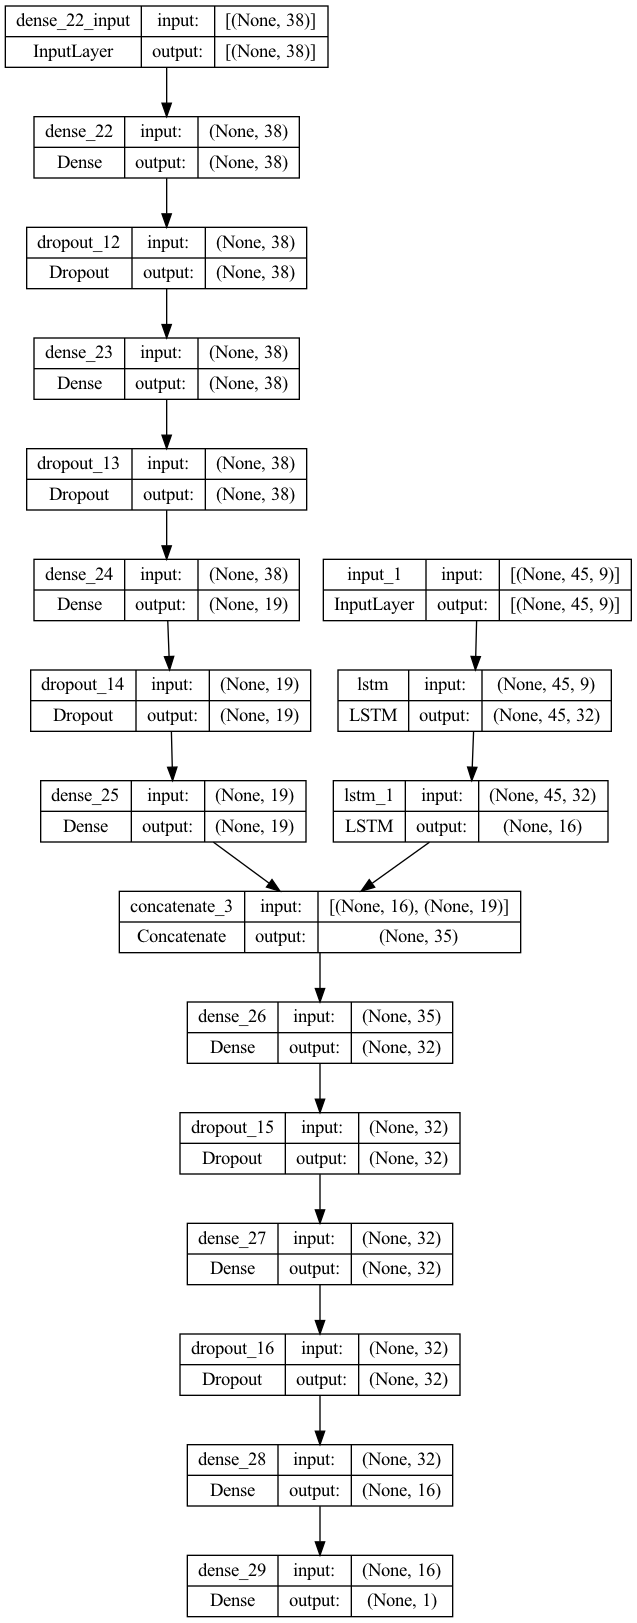

In [21]:
model = load_model("data/tf_models/final_model/model-53-0.5709.h5")
plot_model(full_model, 'full_model.png', show_shapes=True)
